## 4.3.2 XGBoost (unvariate data)

### Tuning XGBoost based on Time-Based Split

## Dataset

In [1]:
import pandas as pd
df = pd.read_csv('Exports of goods and services (constant 2015 US$).csv')

In [2]:
df.head()

,Year,Exports of goods and services (constant 2015 US$)
0,1960,2.070970e+10
1,1961,2.321990e+10
2,1962,2.628075e+10
3,1963,2.894582e+10
4,1964,3.254012e+10


In [3]:
print('size of dataset:', len(df))

size of dataset: 63


# Plot the Series to see Trend and Seasonality

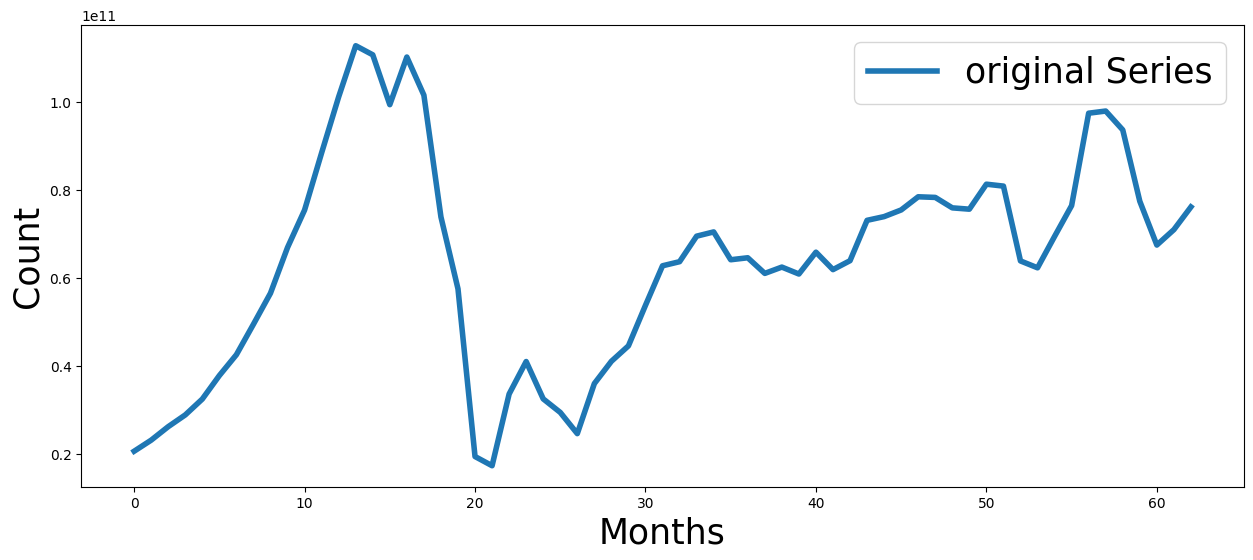

In [4]:
from matplotlib import pyplot as plt
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(6)
plt.plot(df['Exports of goods and services (constant 2015 US$)'], linewidth = 4, label = "original Series")
plt.legend(fontsize=25)
plt.xlabel('Year', fontsize = 25)
plt.ylabel('Count', fontsize = 25)
plt.show()

# Convert it into a Sequence to Sequence Prediction Problem
- Using 12 years data to predict for the next 6 years

In [10]:
def Tranform_dataset(input_length, output_length, data):
    
    df = data.copy()
    
    #input columns creation
    i = 1
    while i < input_length:
        df[f'x_{i}'] = df['Exports of goods and services (constant 2015 US$)'].shift(-i)
        i = i + 1
    
    #output columns creations
    j = 0
    while j < output_length:
        df[f'y_{j}'] = df['Exports of goods and services (constant 2015 US$)'].shift(-output_length-j)
        j = j + 1
    
    #drop some of the last columns
    df = df.dropna(axis=0)
    
    return df

In [11]:
full_data = Tranform_dataset(12, 6, df)
print(len(full_data))

52


In [12]:
full_data.head()

,Year,Exports of goods and services (constant 2015 US$),x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,y_0,y_1,y_2,y_3,y_4,y_5
0,1960,2.070970e+10,2.321990e+10,2.628075e+10,2.894582e+10,3.254012e+10,3.787242e+10,4.260243e+10,4.951140e+10,5.655588e+10,6.691503e+10,7.540928e+10,8.838618e+10,4.260243e+10,4.951140e+10,5.655588e+10,6.691503e+10,7.540928e+10,8.838618e+10
1,1961,2.321990e+10,2.628075e+10,2.894582e+10,3.254012e+10,3.787242e+10,4.260243e+10,4.951140e+10,5.655588e+10,6.691503e+10,7.540928e+10,8.838618e+10,1.010856e+11,4.951140e+10,5.655588e+10,6.691503e+10,7.540928e+10,8.838618e+10,1.010856e+11
2,1962,2.628075e+10,2.894582e+10,3.254012e+10,3.787242e+10,4.260243e+10,4.951140e+10,5.655588e+10,6.691503e+10,7.540928e+10,8.838618e+10,1.010856e+11,1.126837e+11,5.655588e+10,6.691503e+10,7.540928e+10,8.838618e+10,1.010856e+11,1.126837e+11
3,1963,2.894582e+10,3.254012e+10,3.787242e+10,4.260243e+10,4.951140e+10,5.655588e+10,6.691503e+10,7.540928e+10,8.838618e+10,1.010856e+11,1.126837e+11,1.106217e+11,6.691503e+10,7.540928e+10,8.838618e+10,1.010856e+11,1.126837e+11,1.106217e+11
4,1964,3.254012e+10,3.787242e+10,4.260243e+10,4.951140e+10,5.655588e+10,6.691503e+10,7.540928e+10,8.838618e+10,1.010856e+11,1.126837e+11,1.106217e+11,9.931424e+10,7.540928e+10,8.838618e+10,1.010856e+11,1.126837e+11,1.106217e+11,9.931424e+10


# X, Y: Full dataset

In [13]:
X_cols = [col for col in full_data.columns if col.startswith('x')]
X_cols.insert(0, 'Exports of goods and services (constant 2015 US$)')

y_cols = [col for col in full_data.columns if col.startswith('y')]
X = full_data[X_cols].values
y = full_data[y_cols].values

print(X.shape, y.shape)

(52, 12) (52, 6)


# Train Test Split: Shuffle = False (Time-based split)

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

print(X_train.shape, X_test.shape)

(36, 12) (16, 12)


# Using Mango to tune the parameters

In [15]:
from mango.tuner import Tuner

from scipy.stats import uniform

param_dict = {"learning_rate": uniform(0.01, 0.5),
              "max_depth": range(5,10),
              "n_estimators": range(5,50),
              "subsample": uniform(0.7, 0.3),
             "objective":['reg:squarederror']}

In [16]:
import xgboost as xgb
import numpy as np

def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

def objective_Xgboost(args_list):
    global X_train, y_train, X_test, y_test, model, count_called
    
    results = []
    for hyper_par in args_list:
        clf = xgb.XGBRegressor(**hyper_par, random_state = 1)
        clf.fit(X_train, y_train.ravel())
        
        y_pred = clf.predict(X_test) 
        error = mape(y_test, y_pred)
        results.append(error)
        
    return results

In [17]:
conf_Dict = dict()
conf_Dict['initial_random']= 10
conf_Dict['batch_size'] = 1
conf_Dict['num_iteration'] = 100
conf_Dict['domain_size'] = 10000

In [18]:
tuner_user = Tuner(param_dict, objective_Xgboost,conf_Dict)

In [19]:
results = tuner_user.minimize()

  0%|          | 0/100 [00:00<?, ?it/s]

In [21]:
print('best hyper parameters:',results['best_params'])
print('best objective:',results['best_objective'])

best hyper parameters: {'learning_rate': 0.1893529357325766, 'max_depth': 7, 'n_estimators': 48, 'objective': 'reg:squarederror', 'subsample': 0.9905588336776323}
best objective: 3.19


# Train the best model

In [22]:
model = xgb.XGBRegressor(**results['best_params'], random_state = 1)
model.fit(X_train, y_train.ravel())
y_pred = model.predict(X_test) 

# See individual sample test predictions

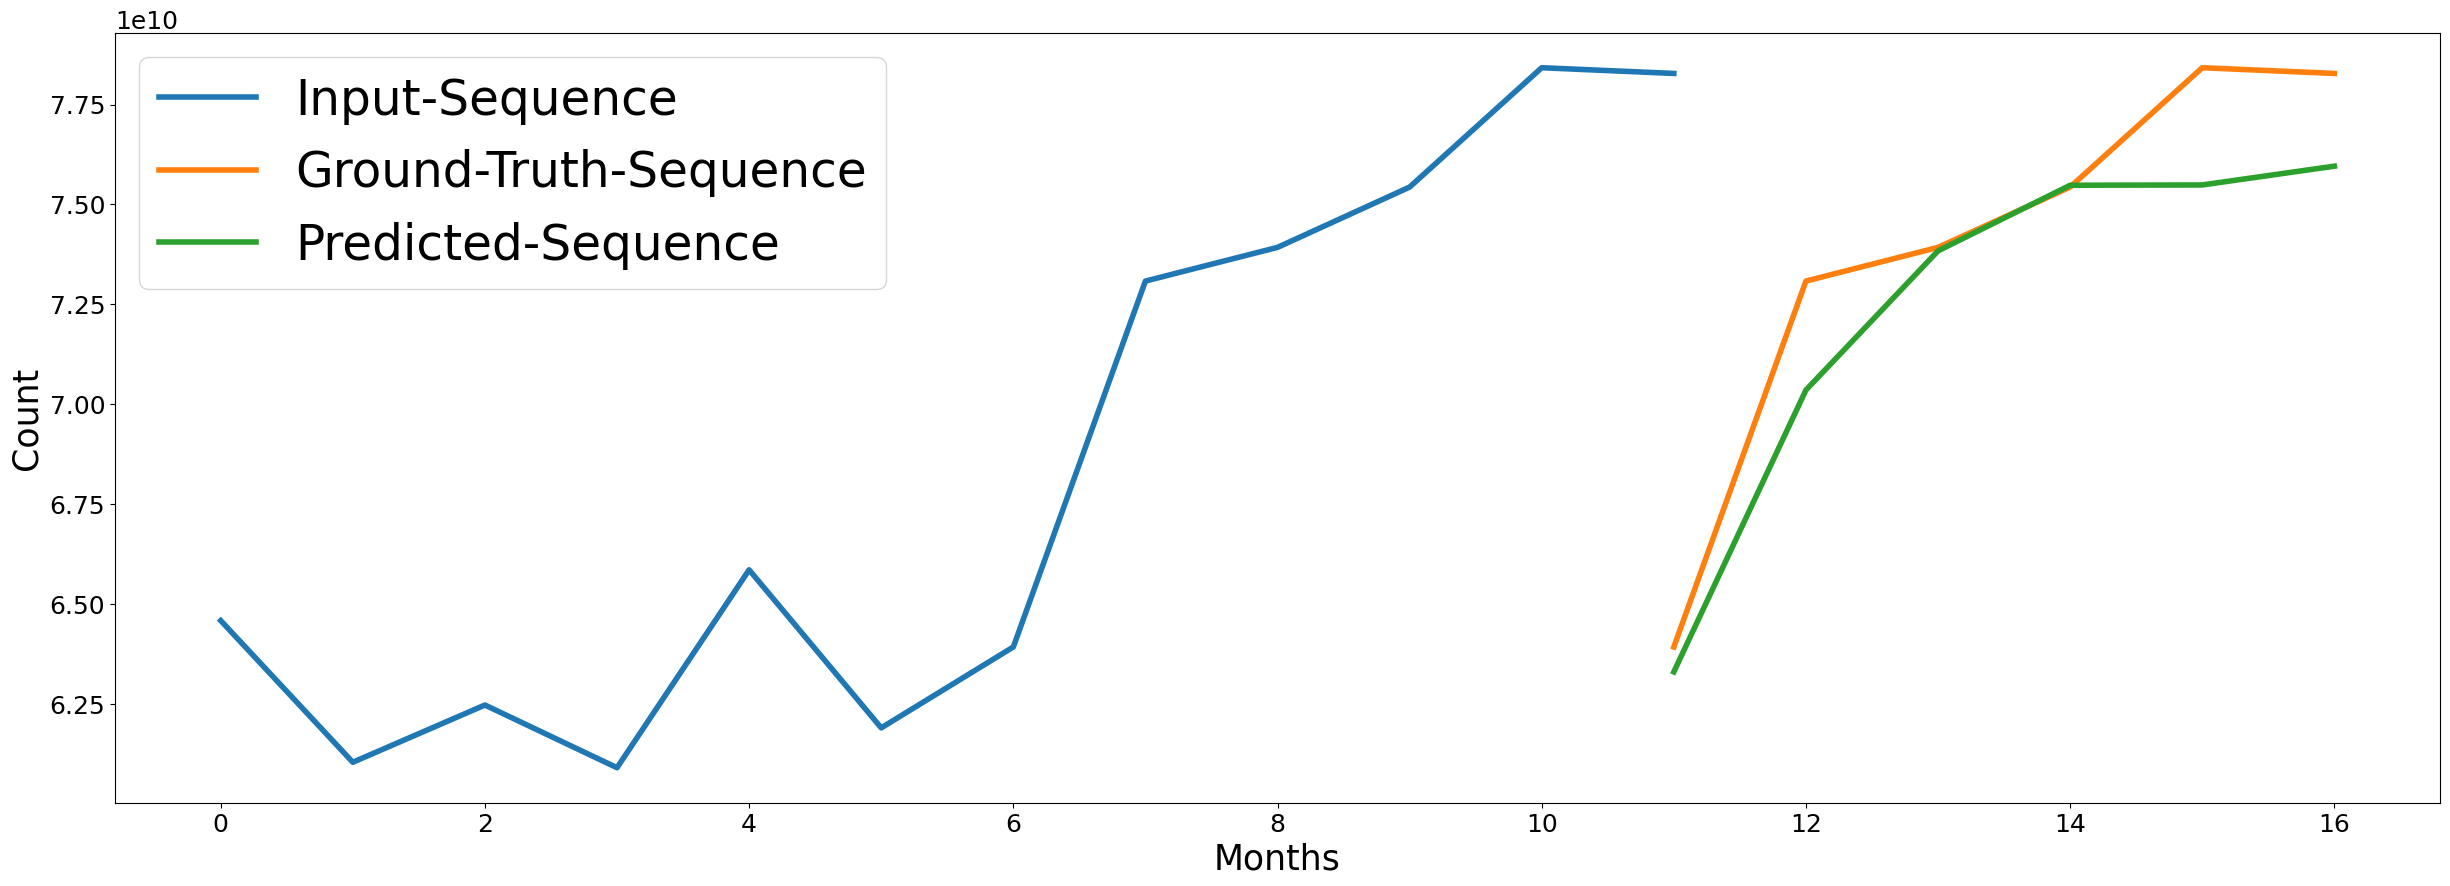

In [23]:
from matplotlib import pyplot as plt
import numpy as np 

fig = plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 18})

plt.plot(np.arange(0, 12, 1), X_test[0],label='Input-Sequence', lw=4)
plt.plot(np.arange(11, 11+6, 1), y_test[0],label='Ground-Truth-Sequence', lw=4)
plt.plot(np.arange(11, 11+6, 1), y_pred[0],label='Predicted-Sequence', lw=4)

plt.xlabel('Months', fontsize = 25)
plt.ylabel('Count', fontsize = 25)
    
plt.legend(fontsize = 35)
plt.show()

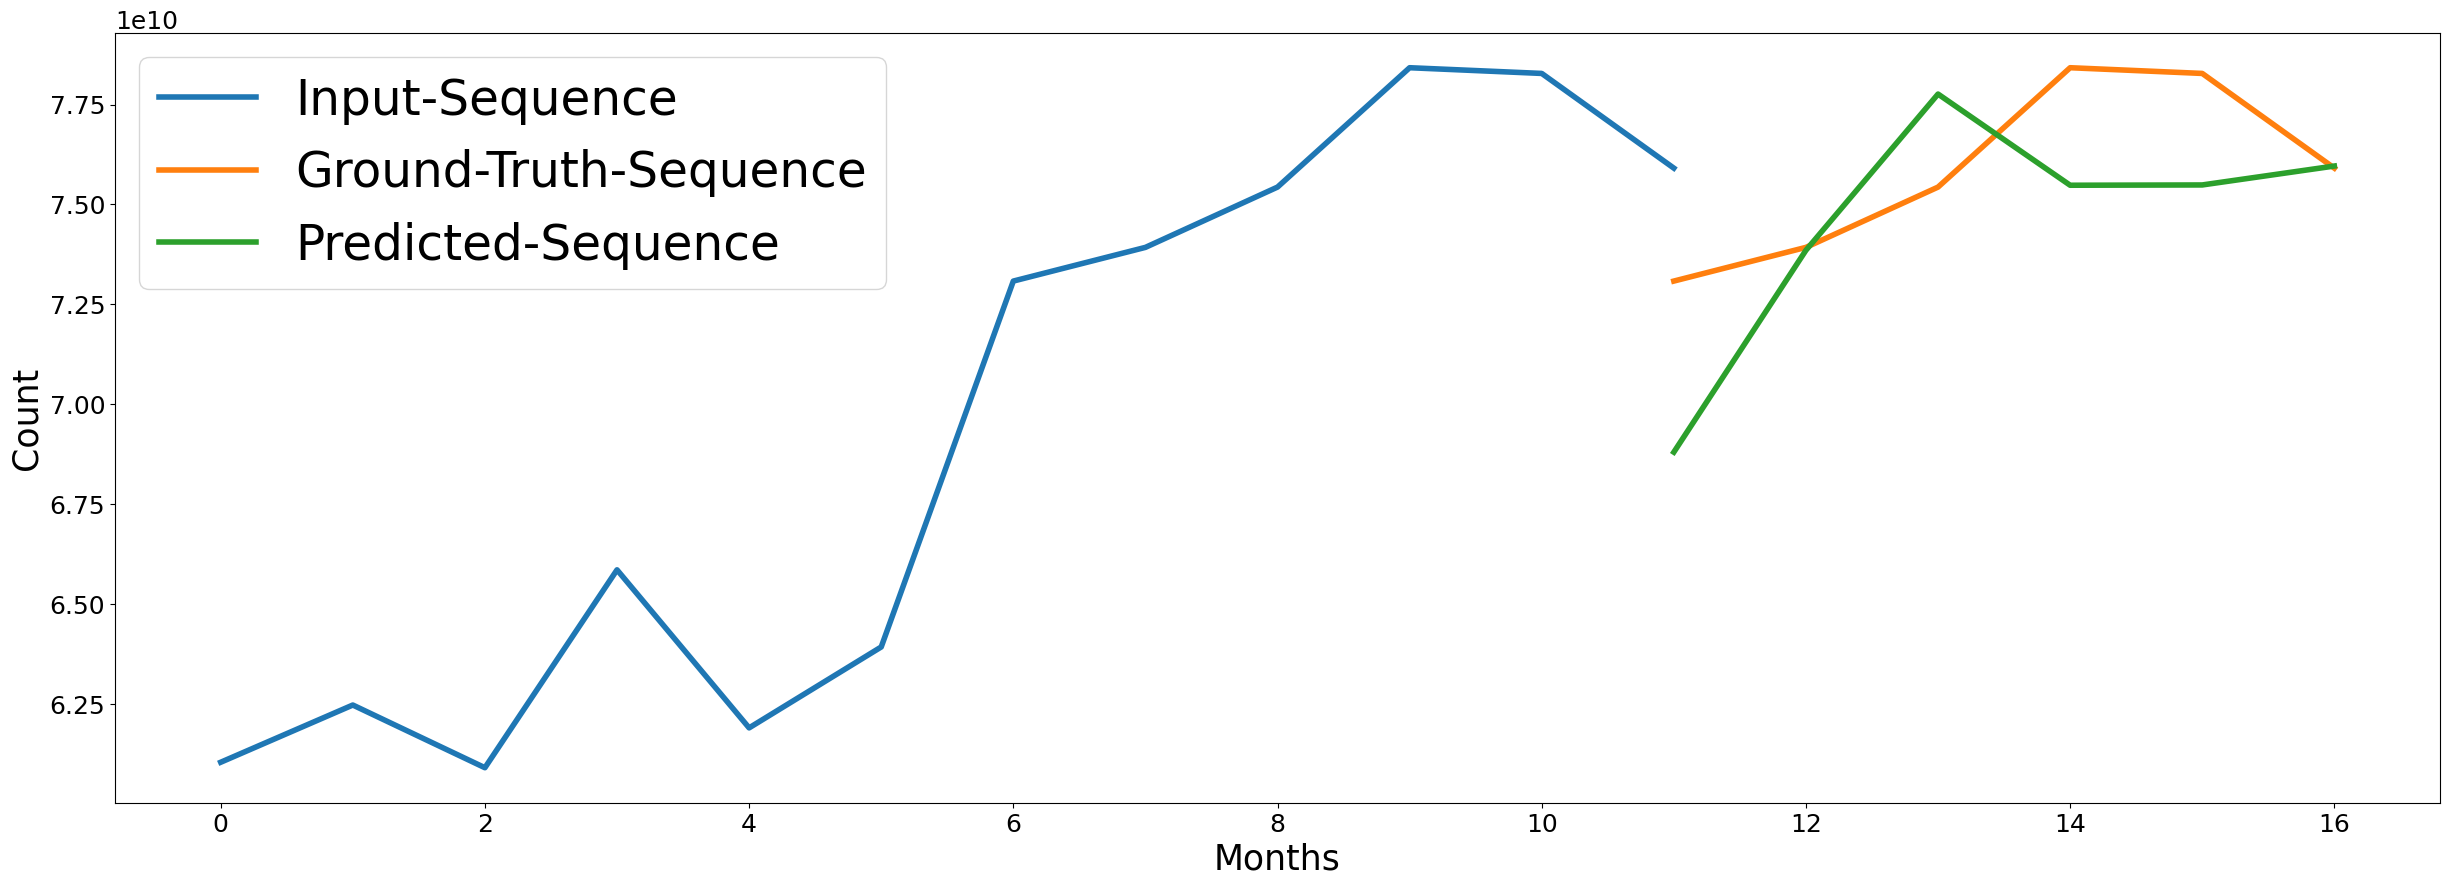

In [24]:
from matplotlib import pyplot as plt
import numpy as np 

fig = plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 18})

plt.plot(np.arange(0, 12, 1), X_test[1],label='Input-Sequence', lw=4)
plt.plot(np.arange(11, 11+6, 1), y_test[1],label='Ground-Truth-Sequence', lw=4)
plt.plot(np.arange(11, 11+6, 1), y_pred[1],label='Predicted-Sequence', lw=4)

plt.xlabel('Months', fontsize = 25)
plt.ylabel('Count', fontsize = 25)
    
plt.legend(fontsize = 35)
plt.show()

# Combine predictions on all the data: Note some of the last samples are left in this simple combination approach

In [25]:
pred = []
truth = []

y_pred = model.predict(X) 

for i in range(len(y_pred)):
    pred.append(y_pred[i][0])
    truth.append(y[i][0])

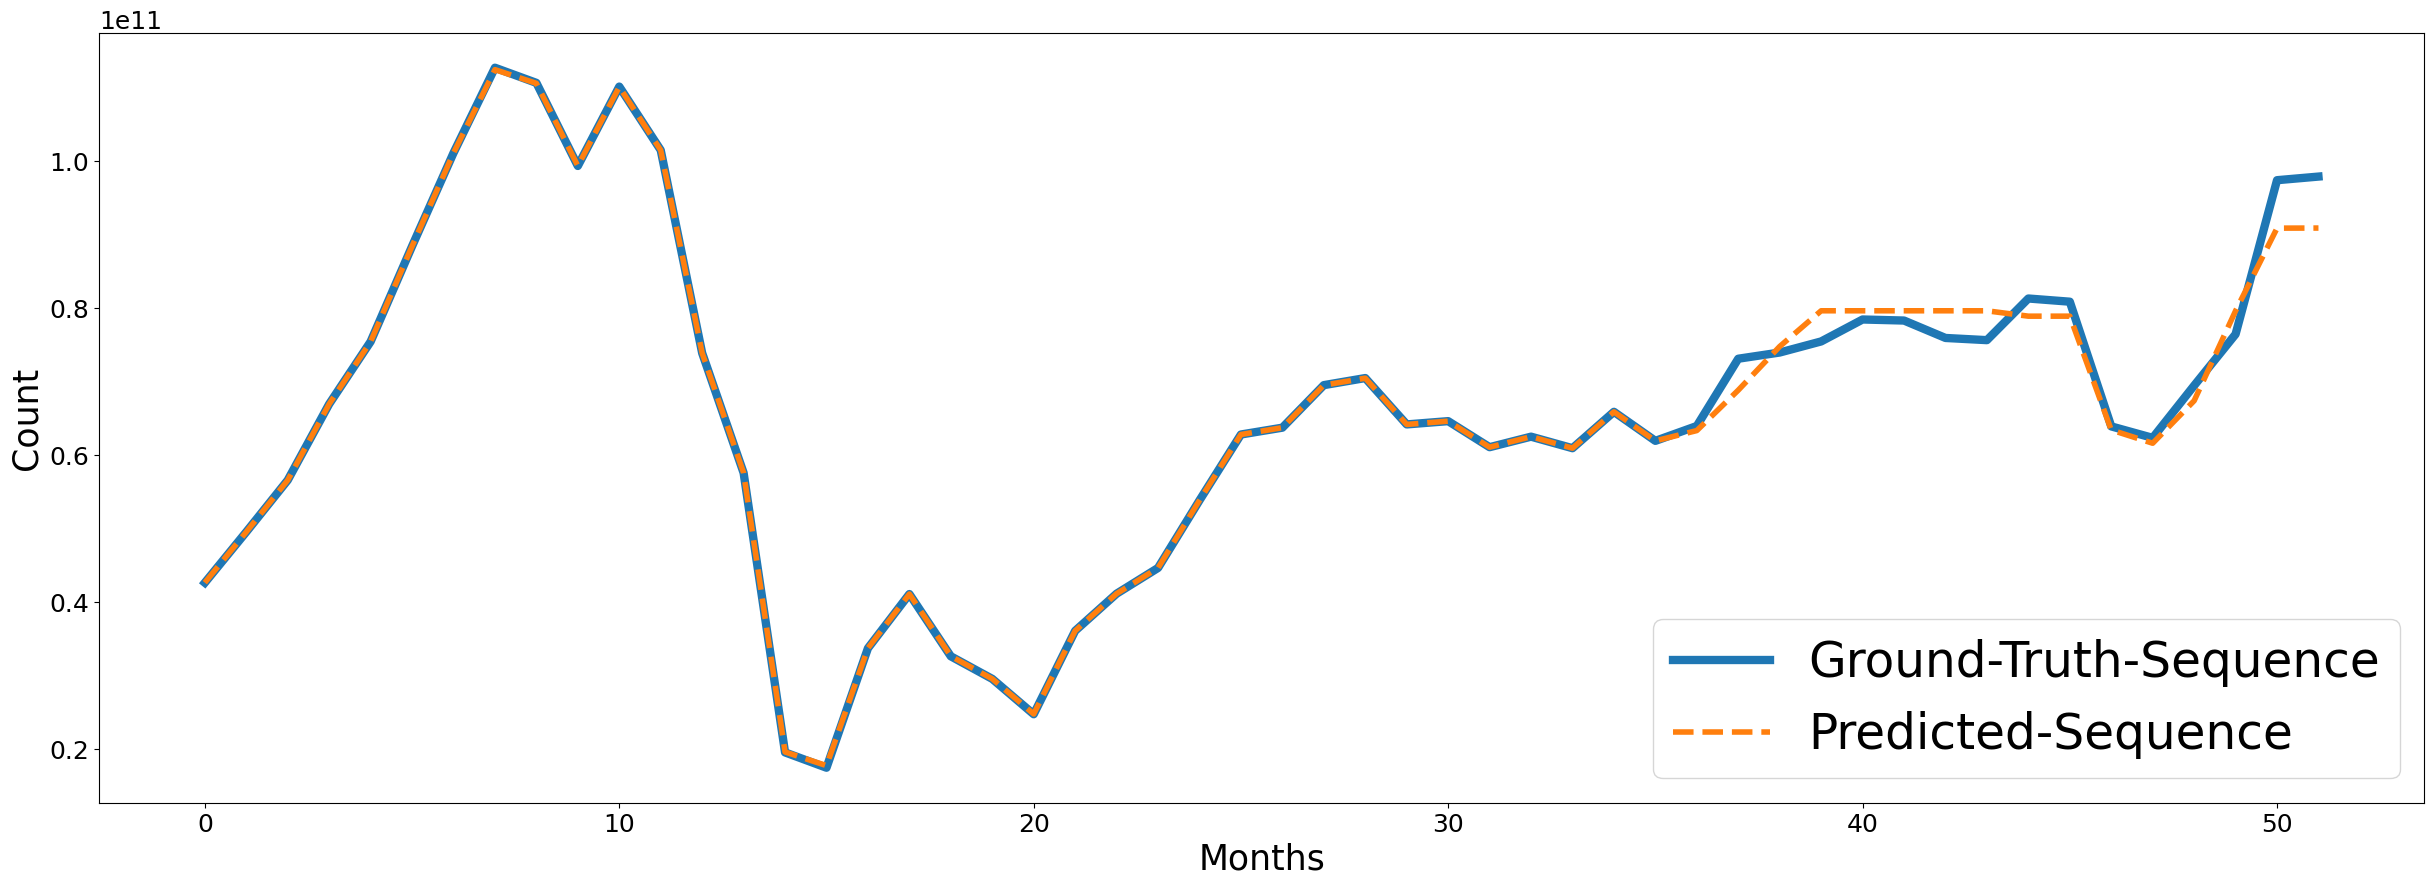

In [26]:
from matplotlib import pyplot as plt
import numpy as np 

fig = plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 18})

plt.plot(truth,label='Ground-Truth-Sequence', lw=6)
plt.plot(pred,label='Predicted-Sequence', lw=4, linestyle='dashed')

plt.xlabel('Year', fontsize = 25)
plt.ylabel('Count', fontsize = 25)
    
plt.legend(fontsize = 35)
plt.show()